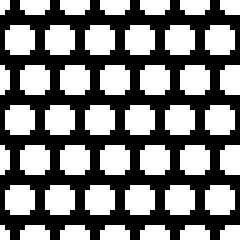

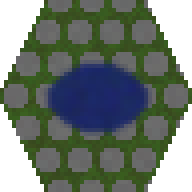

final.shape='hex.flat'


In [3]:
from PIL import ImageFilter

from jabutiles.tilegen import TileGen
from jabutiles.texture import Texture
from jabutiles.mask import Mask
from jabutiles.tile import Tile



img1 = TileGen.gen_texture_tile((48, 48), "grass").image
img2 = TileGen.gen_texture_tile((48, 48), "stone").image
img3 = TileGen.gen_texture_tile((48, 48), "water").image

img4 = TileGen.gen_brick_pattern_mask(48, 6, 2, 1).image
img5 = TileGen.gen_blobs_mask((48, 48), [((24, 24), (12, 8))]).image
img6 = TileGen.gen_hex_mask((48, 48), "flat").image

text1 = Texture(img1)
text2 = Texture(img2)
text3 = Texture(img3)
mask1 = (Mask(img4)
    .offset((-1, 3))
    # .filter(ImageFilter.Kernel((3,3), (1/16,1/8,1/16,1/8,1,1/8,1/16,1/8,1/16)))
)
mask2 = Mask(img5).filter(ImageFilter.SMOOTH)
mask3 = Mask(img6, "hex.flat")

mask1.display(5)

final = Tile.merge_tiles(
    (text1, None),
    (text2, mask1),
    (text3, mask2),
    (None, mask3),
)
final.display(4)
print(f"{final.shape=}")

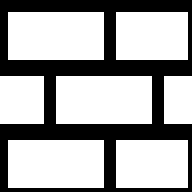

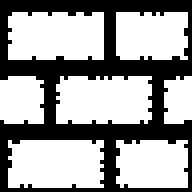

In [4]:
m = Mask(TileGen.gen_brick_pattern_mask((48, 48), (24, 12), (3, 4), 0).image).offset((-1, -1))
m.display(4)
m.invert().outline(1, "white", True, 0.2).invert().display(4)

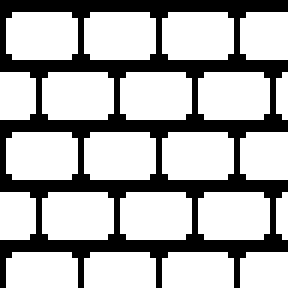

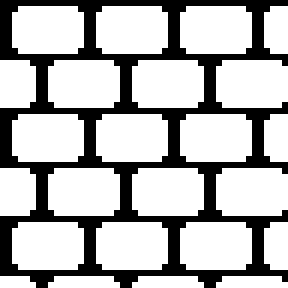

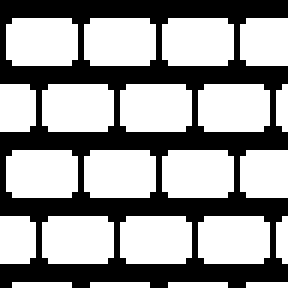

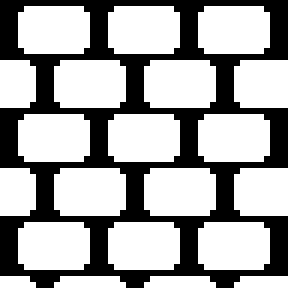

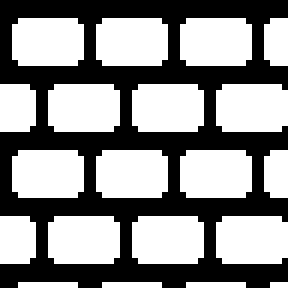

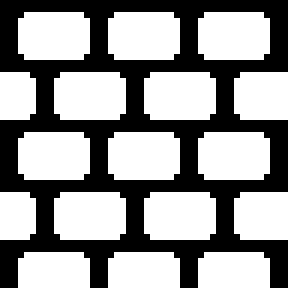

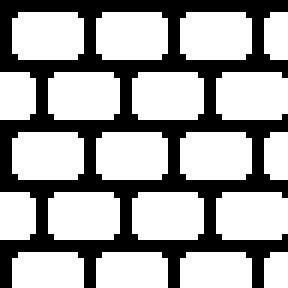

In [5]:
from PIL import Image, ImageDraw, ImageOps
from jabutiles.utils import display_image

def gen_brick_pattern_mask(
        size: int | tuple[int, int],
        brick_size: int | tuple[int, int],
        gap_size: int | tuple[int, int] = 1,
        row_offset: int = None,
        edge_size: int = 0,
        invert: bool = True,
        **params: dict,
    ) -> Mask:
    """
    """
    
    # Parameters setup
    DEBUG: bool = params.get("debug", False)
    
    fval: int = 255 if not DEBUG else 127
    
    if isinstance(size, int): size = (size, size)
    if isinstance(gap_size, int): gap_size = (gap_size, gap_size)
    if isinstance(brick_size, int): brick_size = (brick_size, brick_size)
    
    # Constants
    MW, MH = size       # Mask Width and Height
    BW, BH = brick_size # Brick Width and Height
    GW, GH = gap_size   # Gap Width and Height
    
    BTW = BW + GW       # Brick Template Width
    BTH = BH + GH       # Brick Template Height
    BRW = MW + 2*(BW+GW)# Brick Row Width
    BRH = BH + GH       # Brick Row Height
    
    HBW = BW//2         # Half Brick Width
    if row_offset is None: row_offset = HBW
    else:                  row_offset %= BTW
    
    GOX = (GW - 0.5) // 2   # Gap Offset on x-axis
    GOY = (GH - 0.5) // 2   # Gap Offset on y-axis
    
    
    # Creates the single brick template
    brick_template = Image.new('L', (BTW, BTH), 0)
    brick_canvas = ImageDraw.Draw(brick_template)
    
    # Draws the gaps
    brick_canvas.line(((0.5, GOY), (BRW+0.5, GOY)), fval, GH)
    brick_canvas.line(((GOX+HBW, 0.5), (GOX+HBW, BRH+0.5)), fval, GW)
    
    # Adds the rounded edges
    if edge_size:
        radius = edge_size + 1
        polyconf = dict(n_sides=4, rotation=45, fill=255)
        
        # Adds the top-left corner
        brick_canvas.regular_polygon((HBW, GH-1, radius), **polyconf)
        # Adds the top-right corner
        brick_canvas.regular_polygon((HBW+GW-1, GH-1, radius), **polyconf)
        
        # Flips the corners top-bottom and pastes them back
        flipped = ImageOps.flip(brick_template)
        brick_template.paste(flipped, (0, GH), flipped)
    
    # Generates the long brick row
    brick_row = Image.new('L', (BRW, BRH), 0)
    for col in range(0, BRW, BTW):
        brick_row.paste(brick_template, (col, 0))
    
    # Pastes the brick rows with offsets
    image = Image.new('L', size, 0)
    for cnt, row in enumerate(range(0, MH, BRH)):
        offset = ((cnt % 2) * row_offset) - (HBW + BTW)
        image.paste(brick_row, (offset, row))
    
    # Images are generated with 1s on 0s, so must be inverted
    if invert:
        image = ImageOps.invert(image)
    
    return Mask(image)




SCALE = 6
SZ = (48, 48)
BS = (12, 8)
RO = None
EW = 1

gen_brick_pattern_mask(SZ, BS, (1, 2), RO, EW).display(SCALE)
gen_brick_pattern_mask(SZ, BS, (2, 1), RO, EW).display(SCALE)
gen_brick_pattern_mask(SZ, BS, (1, 3), RO, EW).display(SCALE)
gen_brick_pattern_mask(SZ, BS, (3, 1), RO, EW).display(SCALE)
gen_brick_pattern_mask(SZ, BS, (2, 3), RO, EW).display(SCALE)
gen_brick_pattern_mask(SZ, BS, (3, 2), RO, EW).display(SCALE)
gen_brick_pattern_mask(SZ, BS, (2, 2), RO, EW).display(SCALE)
# gen_brick_pattern_mask(SZ, BS, (6, 6), RO, EW)#.display(SCALE)
# gen_brick_pattern_mask(SZ, BS, (7, 7), RO, EW)#.display(SCALE)
# gen_brick_pattern_mask(SZ, BS, (8, 8), RO, EW)#.display(SCALE)
# gen_brick_pattern_mask(SZ, BS, (9, 9), RO, EW)#.display(SCALE)

# OLD

In [ ]:
# from typing import Self, Type, TypeVar, Generic, Literal, Sequence

# import numpy as np
# from PIL import Image, ImageOps, ImageDraw, ImageChops, ImageFilter, ImageEnhance

# from jabutiles.utils import coalesce, clamp, combine_choices
# from jabutiles.configs import Shapes

# B = TypeVar('B', bound='BaseImage')



# class BaseImage(Generic[B]):
#     # DUNDERS # ----------------------------------------------------------------
#     def __init__(self,
#             image: str | Image.Image | np.typing.NDArray = None,
#             **params,
#         ) -> None:
        
#         self._builder = params.get("builder", BaseImage)
#         self.image: Image.Image
        
#         if isinstance(image, Image.Image):
#             self.image = image
        
#         elif isinstance(image, str):
#             self.image = Image.open(image)
        
#         elif isinstance(image, np.ndarray):
#             self.image = Image.fromarray(image)
        
#         else:
#             # A magenta dot
#             self.image = Image.new('RGB', (1, 1), (255, 0, 255))
        
#         # print("BaseImage.__init__")
    
#     def __str__(self) -> str:
#         return f"BASE | size:{self.size} mode:{self.mode}"
    
#     def __repr__(self):
#         try:
#             display(self.image) # type: ignore
        
#         finally:
#             return self.__str__()
    
#     # PROPERTIES # -------------------------------------------------------------
#     @property
#     def mode(self) -> str:
#         return self.image.mode
    
#     @property
#     def size(self) -> tuple[int, int]:
#         return self.image.size
    
#     @property
#     def width(self) -> int:
#         return self.size[0]
    
#     @property
#     def height(self) -> int:
#         return self.size[1]
    
#     @property
#     def as_array(self) -> np.typing.NDArray:
#         """Returns the Tile as a numpy array.
#         Useful for matrix operations.
        
#         Returns:
#             np.ndarray: The numpy array.
#         """
        
#         return np.array(self.image)
    
#     # METHODS # ----------------------------------------------------------------
#     # BASIC INTERFACES
#     def copy(self) -> B:
#         """Returns a deep copy."""
        
#         return self._builder(self.image.copy(), builder=self._builder)
    
#     def copy_with_params(self,
#             image: Image,
#         ) -> B:
#         """Returns a deep copy but keeping the original parameters."""
        
#         # print("BaseImage.copy_with_params")
        
#         return self._builder(image, builder=self._builder)
    
#     def display(self,
#             factor: float = 1.0,
#             resample: Image.Resampling = Image.Resampling.NEAREST,
#         ) -> None:
#         """Displays the Image on a python notebook."""
        
#         display(ImageOps.scale(self.image, factor, resample)) # type: ignore
    
#     # IMAGE OPERATIONS
#     def rotate(self,
#             angle: int,
#             expand: bool = True,
#         ) -> B:
#         """Rotates the Image counter clockwise.
        
#         Args:
#             angle (int): How many degrees to rotate CCW.
#             expand (bool, optional): If the image resizes to acommodate the rotation. Defaults to True.
        
#         Returns:
#             The rotated Image
#         """
        
#         image = self.image.rotate(int(angle), expand=expand)
        
#         return self.copy_with_params(image)
    
#     def mirror(self,
#             axis: Literal['x', 'y', 'p', 'n'],
#         ) -> B:
#         """Mirrors the Image in the horizontal, vertical or diagonal directions.  
        
#         Args:
#             `axis`, one of:
#             - `x`, top <-> bottom, on horizontal axis
#             - `y`, left <-> right, on vertical axis
#             - `p`, top left <-> bottom right, on diagonal x=y axis (positive)
#             - `n`, bottom left <-> top right, on diagonal x=-y axis (negative)
        
#         Returns:
#             The mirrored Image.
#         """
        
#         match axis:
#             case 'x': image = ImageOps.flip(self.image)
#             case 'y': image = ImageOps.mirror(self.image)
#             case 'p': image = self.image.transpose(Image.Transpose.TRANSVERSE)
#             case 'n': image = self.image.transpose(Image.Transpose.TRANSPOSE)
#             case _:   image = self.image.copy()
        
#         return self.copy_with_params(image)
    
#     def scale(self,
#             factor: float | tuple[float, float],
#             resample: Image.Resampling = Image.Resampling.NEAREST,
#         ) -> B:
#         """'scale' as in 'stretch by factor(x,y) or factor(s)'"""
        
#         if isinstance(factor, (int, float)):
#             image = ImageOps.scale(self.image, factor, resample)
        
#         elif isinstance(factor, tuple):
#             w, h = self.size
#             newsize = (int(w * factor[0]), int(h * factor[1]))
#             image = self.image.resize(newsize, resample)
        
#         else:
#             # print(f"Strange parameters")
#             image = self.image.copy()
        
#         return self.copy_with_params(image)
    
#     def crop(self,
#             box: tuple[int, int, int, int],
#         ) -> B:
#         """Removes the border around the bounding box.  
#         Order: (left, top, right, bottom)."""
        
#         image = self.image.crop(box)
        
#         return self.copy_with_params(image)
    
#     def take(self,
#             pos: tuple[int, int],
#             size: tuple[int, int],
#         ) -> B:
#         """Similar to crop but accepts wrapping values."""
        
#         x0, y0 = pos
#         width, height = size
#         wrap_width, wrap_height = self.size
        
#         xidx = (np.arange(x0, x0+width)  % wrap_width)
#         yidx = (np.arange(y0, y0+height) % wrap_height)
        
#         crop = self.as_array[np.ix_(yidx, xidx)]
        
#         return self.copy_with_params(crop)
    
#     def offset(self,
#             offset: tuple[int, int],
#             wrap: bool = True,
#         ) -> B:
#         """'Slides' the texture by the offset amount."""
        
#         if wrap:
#             width, height = self.size
#             offx, offy = offset
            
#             posx = (width - offx) % width
#             posy = (height - offy) % height
            
#             return self.take((posx, posy), self.size)
        
#         else:
#             base_image = Image.new(self.mode, self.size, "black")
#             base_image.paste(self.image, offset)
            
#             return self.copy_with_params(base_image)
    
#     def filter(self,
#             filters: ImageFilter.Filter | list[ImageFilter.Filter],
#             pad: int = 4,
#         ) -> B:
        
#         w, h = self.size
        
#         # Pads the image with itself to avoid filter bleeding
#         image = self.take((w-pad, h-pad), (w+pad*2, h+pad*2)).image
        
#         filters = coalesce(filters, list)
#         for f in filters:
#             image = image.filter(f)
        
#         # Crops the extra border, restoring the original size
#         image = ImageOps.crop(image, pad)
        
#         return self.copy_with_params(image)
    
#     # ADVANCED OPERATIONS
#     def outline(self,
#             thickness: float = 1.0,
#             color: str | tuple[int, int, int] = "white",
#             combine: bool = True,
#         ) -> B:
        
#         ref_image = self.image.convert("RGBA")
#         base_image = Image.new(ref_image.mode, ref_image.size, (0, 0, 0, 0))
#         canvas = ImageDraw.Draw(base_image)
        
#         # Ensures thickness is always at least 1
#         T = clamp(thickness, (1, 1000))
#         W, H = ref_image.size
#         edge = ref_image.filter(ImageFilter.FIND_EDGES).load()
        
#         for x in range(W):
#             for y in range(H):
#                 if not edge[x,y][3]:
#                     continue
                
#                 if T % 1 == 0: # 1, 2, 3, ...round corners
#                     canvas.ellipse((x-T, y-T, x+T, y+T), fill=color)
                
#                 else: # 1.5, 2.5, 3.5, ... square corners
#                     canvas.rectangle((x-T+0.5, y-T+0.5, x+T-0.5, y+T-0.5), fill=color)
        
#         if combine:
#             base_image.paste(ref_image, mask=ref_image)
        
#         else:
#             alpha = ImageEnhance.Brightness(ref_image).enhance(256)
#             base_image = ImageChops.subtract(base_image, alpha)
        
#         return self.copy_with_params(base_image)
    



# class Mask(BaseImage["Mask"]):
#     """A Mask is a special 'Tile' with a shape and orientation"""
    
#     # DUNDERS # ----------------------------------------------------------------
#     def __init__(self,
#             image: str | Image.Image | np.typing.NDArray = None,
#             shape: Shapes = None,
#             edges: str = None,
#             **params,
#         ) -> None:
        
#         params["builder"] = Mask
#         super().__init__(image, **params)
        
#         # Ensures all masks are Luminance channel only
#         self.image = self.image.convert('L')
        
#         self.shape: Shapes = shape if shape is not None else 'ort'
#         self.edges: str = edges # .replace('x', '.') # TODO: autodetect
        
#         # print("Mask.__init__")
    
#     def __str__(self) -> str:
#         return f"MASK | size:{self.size} mode:{self.mode} shape:{self.shape} edges:{self.edges}"
    
#     # STATIC METHODS # ---------------------------------------------------------
#     @staticmethod
#     def _create_symmetrical_outline(
#             size: tuple[int, int],
#             lines: list[tuple[tuple[float]]],
#             fill: bool = True,
#             **params,
#         ) -> Image.Image:
        
#         image = Image.new("L", size, 0)
#         draw  = ImageDraw.Draw(image)
        
#         for line in lines:
#             draw.line(line, fill=255)
        
#         image.paste(ImageOps.flip(image), mask=ImageOps.invert(image))
#         image.paste(ImageOps.mirror(image), mask=ImageOps.invert(image))
        
#         if fill:
#             ImageDraw.floodfill(image, (size[0] / 2, size[1] / 2), 255)
        
#         return image
    
#     @staticmethod
#     def merge_masks(
#             masks: Sequence["Mask"] | dict[str, "Mask"],
#             **params,
#         ) -> "Mask":
        
#         assert len(masks) >= 2, "Insufficient masks to be merged (<2)"
        
#         if isinstance(masks, Sequence):
#             base = masks[0].as_array
            
#             for mask in masks[1:]:
#                 base |= mask.as_array
            
#             return Mask(base, masks[-1].shape)
        
#         if isinstance(masks, dict):
#             mask_data = masks.copy()
#             base_edge, base_mask = mask_data.popitem()
            
#             # Iterates and combines them
#             for edge, mask in mask_data.items():
#                 base_edge = combine_choices(base_edge, edge)
#                 base_mask = Mask.merge_masks([base_mask, mask])
            
#             return base_edge, base_mask
        
#         return None
    
#     # METHODS # ----------------------------------------------------------------
#     # BASIC INTERFACES
#     def copy_with_params(self,
#             image: Image,
#         ) -> Self:
#         """Returns a deep copy but keeping the original parameters."""
        
#         params = dict(shape=self.shape, edges=self.edges, builder=self._builder)
#         # print(f"Mask.copy_with_params:\n{params=}")
#         return self._builder(image, **params)
    
#     # IMAGE OPERATIONS
#     def invert(self) -> Self:
#         """'invert' as in 'negative'"""
        
#         image = ImageOps.invert(self.image)
        
#         return self.copy_with_params(image)
    



# class Texture(BaseImage["Texture"]):
#     """A Texture is a simple image."""
    
#     # DUNDERS # ----------------------------------------------------------------
#     def __init__(self,
#             image: str | Image.Image | np.typing.NDArray = None,
#             **params,
#         ) -> None:
        
#         params["builder"] = Texture
#         super().__init__(image, **params)
        
#         # Ensures all textures are full channel
#         self.image = self.image.convert('RGBA')
        
#         # print("Texture.__init__")
    
#     def __str__(self) -> str:
#         return f"TEXTURE | size:{self.size} mode:{self.mode}"
    
#     # METHODS # ----------------------------------------------------------------
#     # BASIC INTERFACES
#     def copy_with_params(self,
#             image: Image,
#         ) -> Self:
#         """Returns a deep copy but keeping the original parameters."""
        
#         params = dict(builder=self._builder)
#         # print(f"Texture.copy_with_params:\n{params=}")
#         return self._builder(image, **params)
    
#     # IMAGE OPERATIONS
#     def brightness(self, factor: float = 1.0) -> Self:
#         if factor == 1.0:
#             return self
        
#         image = ImageEnhance.Brightness(self.image).enhance(factor)
        
#         return self.copy_with_params(image)
    
#     def color(self, factor: float = 1.0) -> "Tile":
#         if factor == 1.0:
#             return self
        
#         image = ImageEnhance.Color(self.image).enhance(factor)
        
#         return self.copy_with_params(image)
    
#     def contrast(self, factor: float = 1.0) -> "Tile":
#         if factor == 1.0:
#             return self
        
#         image = ImageEnhance.Contrast(self.image).enhance(factor)
        
#         return self.copy_with_params(image)
    
#     def cutout(self,
#             mask: "Mask",
#         ) -> "Tile":
#         """Think of 'cutout' as in 'cookie cutter'.  
#         Cuts a Texture to generate a Tile.
#         """
        
#         image = self.image.copy()
#         image.putalpha(mask.image)
        
#         return Tile(image, mask.shape)



# class Tile(Texture):
#     """A Tile is a Texture with a purpose and a shape.  
#     Can be thought as the final stage of a Texture + Mask.
#     """
    
#     # DUNDERS # ----------------------------------------------------------------
#     def __init__(self,
#             image: str | Image.Image | np.typing.NDArray = None,
#             shape: Shapes = None,
#             **params,
#         ) -> None:
        
#         params["builder"] = Tile
#         super().__init__(image, **params)
        
#         # Ensures all tiles are full channel
#         self.image: Image.Image = self.image.convert('RGBA')
        
#         self.shape: Shapes = shape if shape is not None else 'ort'
        
#         # print("Tile.__init__")
    
#     def __str__(self) -> str:
#         return f"TILE | size:{self.size} mode:{self.mode} shape:{self.shape}"
    
#     # STATIC METHODS # ---------------------------------------------------------
#     @staticmethod
#     def merge_tiles(*tiles: tuple["Texture", "Mask"]) -> "Tile":
#         """
#         tiles = [(tile, mask), (tile, mask), ...]
#         """
#         assert len(tiles) >= 2
        
#         FIRST: tuple[Texture, Mask] = tiles[0]
#         LAST: tuple[Texture, Mask] = tiles[-1]
        
#         last_is_cut: bool = LAST[0] is None
        
#         start_at: int = 0
#         end_at: int = len(tiles)
#         shape: Shapes = "ort"
        
#         # The first texture is used in full
#         if FIRST[1] is None:
#             image = tiles[0][0].image.copy()
#             start_at = 1
        
#         # A black template is used
#         else:
#             SIZE = tiles[0][0].size
#             image = Image.new('RGBA', SIZE, (0, 0, 0, 0))
        
#         # If the last tuple is just the mask, do the cutout
#         if last_is_cut:
#             end_at = end_at - 1
        
#         for tile, mask in tiles[start_at:end_at]:
#             image.paste(tile.image, mask=mask.image)
#             shape = mask.shape
        
#         tile = Tile(image, shape)
        
#         if last_is_cut:
#             tile = tile.cutout(LAST[1])
        
#         return tile
    
#     # METHODS # ----------------------------------------------------------------
#     # BASIC INTERFACES
#     def copy_with_params(self,
#             image: Image,
#         ) -> Self:
#         """Returns a deep copy but keeping the original parameters."""
        
#         params = dict(shape=self.shape, builder=self._builder)
#         # print(f"Mask.copy_with_params:\n{params=}")
#         return self._builder(image, **params)
    
#     # IMAGE OPERATIONS
#     def overlay(self,
#             head: "Tile",
#             mask: "Mask" = None,
#             alpha: float = 0.5,
#         ) -> "Tile":
#         # TODO: review
#         """Merges two tiles into a new one.
#         Must have a MASK or alpha value (default, 0.5).
        
#         If using a MASK, it must have the same dimensions as both DATA Tiles.
#         The pixel values from the MASK range from 0 (full base) to 255 (full head).
        
#         The alpha value is used if no MASK is present.
#         Its value is applied to the Tiles as a whole, not by pixel.
        
#         Args:
#             base (Tile): The Tile that goes on the bottom.
#             head (Tile): The Tile that goes on top.
#             mask (Tile, optional): A special Tile that controls how each pixel is merged. Defaults to None.
#             alpha (float, optional): A value that controls how all pixels are merged. Defaults to 0.5.
        
#         Returns:
#             Tile: A new Tile resulting from the combination of both Tiles.
#         """
        
#         if mask is None:
#             image = Image.blend(self.image, head.image, alpha)
#             shape = self.shape
        
#         else:
#             image = Image.composite(head.image, self.image, mask.image)
#             shape = mask.shape
        
#         return Tile(image, shape)
    


# TODO: Test all this shit